In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import argparse
import time
import datetime
from sklearn.metrics import r2_score
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import time
import os, glob
from torch.utils.data import Dataset, DataLoader

from torch.utils import data


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [4]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
            print('Make dir')
            return directory
        else:
            return directory
    except OSError:
        print('ERROR: Creating directory.' + directory)


def set_data(data_path):
    output_dic = {}

    input_dataset = glob.glob(os.path.join(os.path.join(data_path+'/', 'input'), '*.txt'))
    output_dataset = glob.glob(os.path.join(os.path.join(data_path+'/', 'output'), '*.txt'))

    input_dataset = np.array([pd.read_csv(input,header=None).values.astype(np.float64) for input in input_dataset])
    output_dataset = np.array([pd.read_csv(output,header=None).values.astype(np.float64) for output in output_dataset])

    output_dic['lstm_output_dataset'] = np.squeeze(output_dataset)
    output_dic['input_dataset'] = input_dataset.reshape([input_dataset.shape[0], input_dataset.shape[1], 1]) if input_dataset.ndim ==2 else input_dataset
    output_dic['output_dataset'] = output_dataset.reshape([output_dataset.shape[0], output_dataset.shape[1], 1]) if output_dataset.ndim ==2 else output_dataset

    return output_dic

In [5]:
dataDir = "D:/MHC/2022/개인자료/kmong/battery_health_등푸른비행선/지진값"

dt = 0.02

train_ratio = 0.8

result_dir = createFolder(directory='./inference_result/')

time_stamp = datetime.datetime.today().strftime("%Y%m%d_%H_%M_%S")

dataset = set_data(data_path=dataDir)

input_dataset = dataset['input_dataset']
output_dataset = dataset['output_dataset']
lstm_output_dataset = dataset['lstm_output_dataset']


In [6]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag + 1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    nsamples = train.shape[0]
    nx, ny = train.shape[1], train.shape[2]
    nsamples_test = test.shape[0]
    nxt, nyt = test.shape[1], test.shape[2]

    train_set = train.reshape((nsamples*nx,ny))
    test_set = test.reshape((nsamples_test*nxt,nyt))

    scaler = scaler.fit(train_set)
    # transform train
    train_scaled = scaler.transform(train_set)
    # transform test
    test_scaled = scaler.transform(test_set)
    return scaler, train_scaled.reshape(nsamples, nx, ny), test_scaled.reshape(nsamples_test, nxt, nyt)

def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]  # push_back
    array = np.array(new_row)
    array = array.reshape(1, len(array))  # convert to 2d
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [7]:
import torch
import torch.nn as nn


class LSTM(nn.Module):
    def __init__(self, input_size, hidden_dim, layers, n_out):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layers = layers
        self.n_out = n_out

        self.hn = torch.zeros(self.layers, 1, hidden_dim)
        self.cn = torch.zeros(self.layers, 1, hidden_dim)

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=self.hidden_dim, num_layers=self.layers,
                            batch_first=True)  # LSTM layer

        self.fc = nn.Linear(self.hidden_dim, self.n_out)

    def forward(self, x, hn, cn):
        X = x.reshape(1, x.shape[0], x.shape[1])
        out_longer, (hn, cn) = self.lstm(X, (hn.detach(), cn.detach()))
        out = out_longer.view(x.shape[0], x.shape[1], out_longer.shape[2])
        out = self.fc(out[:, -1, :])
        return out.unsqueeze(-1), (hn, cn)

def set_lstm(input_size, params, DEVICE):

    hidden_dim = params['hidden_dim']
    n_out = params['output_dim']
    layers = params['layers']

    train_model = LSTM(input_size=input_size, hidden_dim=hidden_dim, n_out=n_out, layers=layers).to(DEVICE)

    return train_model



In [8]:
class My_Dataset(data.Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [9]:
class Model_Learner():

    def __init__(self, DEVICE, type='lstm'):
        self.DEVICE = DEVICE
        self.type = type
        self.train_dict = {'lstm': self.lstm_train}  # 각 model type에 따라 train 함수를 다르게 호출한다.
        self.eval_dict = {'lstm': self.lstm_evaluate}  # 각 model type에 따라 evaluate 함수를 다르게 호출한다.
        self.loss_dict = {'lstm': torch.nn.MSELoss}  # 각 model type에 따라 loss 함수를 다르게 호출한다.

    # 모델 별로 학습을 하기 위한 함수
    def nn_learning(self, nn_model, ls_dict, data_dict):

        optimizer = torch.optim.Adam(nn_model.parameters(), lr=ls_dict['learning_rate'])

        self.train_loader = torch.utils.data.DataLoader(dataset=My_Dataset(data_dict['train_x'], data_dict['train_y']),
                                                        # 시계열 데이터 이므로 shuffle 도 하지 않고, batch로 나누어지지 않는 값 또한 drop 하지 않는다.
                                                        batch_size=ls_dict['BATCH_SIZE'], shuffle=False,
                                                        drop_last=False)

        self.test_loader = torch.utils.data.DataLoader(dataset=My_Dataset(data_dict['test_x'], data_dict['test_y']),
                                                       # 시계열 데이터 이므로 shuffle 도 하지 않고, batch로 나누어지지 않는 값 또한 drop 하지 않는다.
                                                       batch_size=ls_dict['BATCH_SIZE'], shuffle=False, drop_last=False)

        criterion = self.loss_dict[self.type]().to(self.DEVICE)

        patience = ls_dict['patience']

        self.avg_train_losses = []
        self.avg_valid_losses = []


        for epoch in range(1, ls_dict['EPOCHS'] + 1):
            train_loss = self.train_dict[self.type](nn_model, self.train_loader, optimizer, criterion)
            test_loss = self.eval_dict[self.type](nn_model, self.test_loader, criterion)

            self.avg_train_losses.append(train_loss)
            self.avg_valid_losses.append(test_loss)

            if epoch % 10 == 0:
                print('epoch:{} train_loss:{:.4f}'.format(epoch, train_loss))
                print('validation_loss:{:.4f}'.format(test_loss))

        return nn_model


    def lstm_train(self, model, train_loader, optimizer, criterion):
        try:
            model.train()
            train_loss = 0
            hn = model.hn
            cn = model.cn

            for batch_idx, (data, target) in enumerate(train_loader):

                data = data.reshape(data.shape[0], 1, data.shape[1])

                data, target = data.to(self.DEVICE), target.type(torch.float32).to(self.DEVICE)
                hypothesis, (hn, cn) = model(data.type(torch.float32), hn, cn)

                loss = criterion(hypothesis, target)

                optimizer.zero_grad()
                train_loss += loss
                loss.backward()
                optimizer.step()
            train_loss /= len(train_loader.dataset)
            return train_loss

        except Exception as e:
            print('train:', e)

    def lstm_evaluate(self, model, test_loader, criterion):
        try:
            model.eval()
            test_loss = 0

            hn = model.hn
            cn = model.cn
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(self.DEVICE), target.type(torch.float32).to(self.DEVICE)

                    hypothesis, (hn, cn) = model(data.type(torch.float32), hn, cn)
                    test_loss += criterion(hypothesis, target)

            test_loss /= len(test_loader.dataset)

            return test_loss
        except Exception as e:
            print('evaluate', e)

In [23]:
train_dict = {'train_x':[], 'test_x':[], 'rawvalues':[], 'len_supervised':[]}

In [24]:
train_indices = int(len(output_dataset) * train_ratio)

train_output_dataset = output_dataset[:train_indices]
test_output_dataset = output_dataset[train_indices:]

train_scaled_dataset = []
test_scaled_dataset = []

for d in train_output_dataset:

    target_data = np.squeeze(d)
    
    raw_values = target_data

    train_dict['rawvalues'].append(raw_values)

    diff_values = difference(raw_values, 1)

    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values

    train_size = int(len(supervised_values) * train_ratio)
    train = supervised_values[0:train_size]
    test = supervised_values[train_size:]

    train_dict['len_supervised'].append(len(supervised_values))

    train_dict['train_x'].append(train)
    train_dict['test_x'].append(test)

train_dict['rawvalues'] = np.asarray(train_dict['rawvalues'])

train_dict['train_x'] = np.asarray(train_dict['train_x'])
train_dict['test_x'] = np.asarray(train_dict['test_x'])


In [25]:
scaler, train_scaled_list, test_scaled_list = scale(train_dict['train_x'], train_dict['test_x'])

In [26]:
nn_parmas ={"learning_rate" : 1e-1,
            "EPOCHS" : 30,
            "BATCH_SIZE" : 50,
            "patience" : 5,
            "hidden_dim" : 6,
            "layers": 1,
            "output_dim": 1
            }


Training and evaluating for time series 0
epoch:10 train_loss:0.0001
validation_loss:0.0000
epoch:20 train_loss:0.0001
validation_loss:0.0000
epoch:30 train_loss:0.0001
validation_loss:0.0000


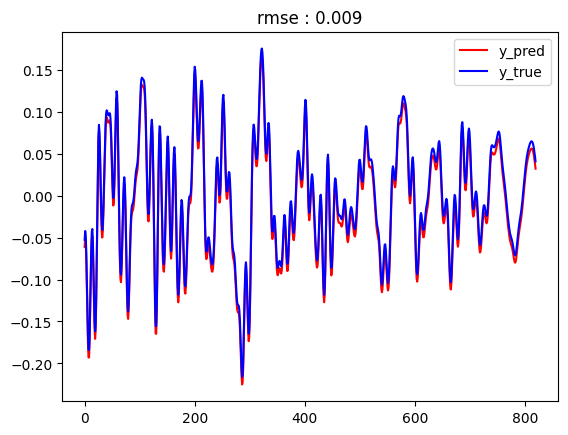

Training and evaluating for time series 1
epoch:10 train_loss:0.0001
validation_loss:0.0000
epoch:20 train_loss:0.0001
validation_loss:0.0000
epoch:30 train_loss:0.0001
validation_loss:0.0000


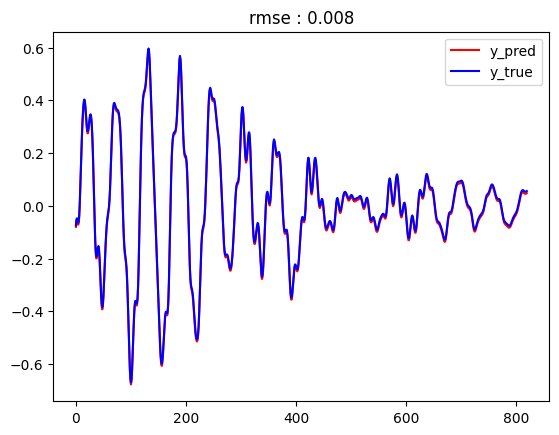

Training and evaluating for time series 2
epoch:10 train_loss:0.0000
validation_loss:0.0000
epoch:20 train_loss:0.0000
validation_loss:0.0000
epoch:30 train_loss:0.0000
validation_loss:0.0000


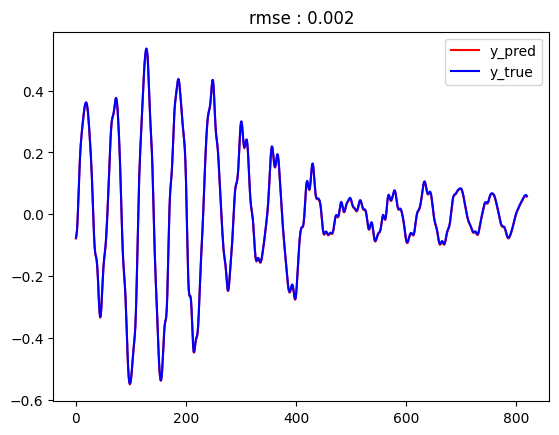

Training and evaluating for time series 3
epoch:10 train_loss:0.0000
validation_loss:0.0000
epoch:20 train_loss:0.0000
validation_loss:0.0000
epoch:30 train_loss:0.0000
validation_loss:0.0000


Training and evaluating for time series 4
epoch:10 train_loss:0.0007
validation_loss:0.0001
epoch:20 train_loss:0.0007
validation_loss:0.0001
epoch:30 train_loss:0.0007
validation_loss:0.0001


Training and evaluating for time series 5
epoch:10 train_loss:0.0006
validation_loss:0.0002
epoch:20 train_loss:0.0006
validation_loss:0.0002
epoch:30 train_loss:0.0006
validation_loss:0.0002


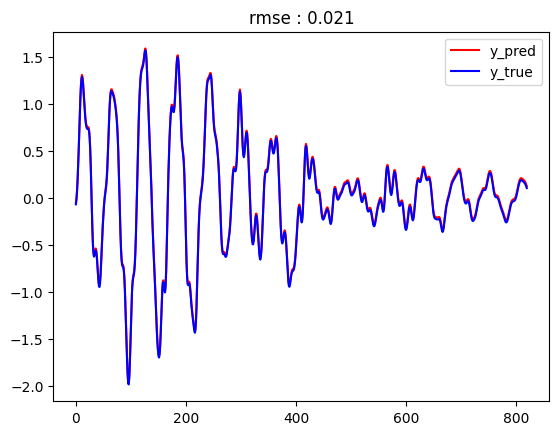

Training and evaluating for time series 6
epoch:10 train_loss:0.0006
validation_loss:0.0002
epoch:20 train_loss:0.0006
validation_loss:0.0002
epoch:30 train_loss:0.0006
validation_loss:0.0002


Training and evaluating for time series 7
epoch:10 train_loss:0.0001
validation_loss:0.0000
epoch:20 train_loss:0.0001
validation_loss:0.0000
epoch:30 train_loss:0.0001
validation_loss:0.0000


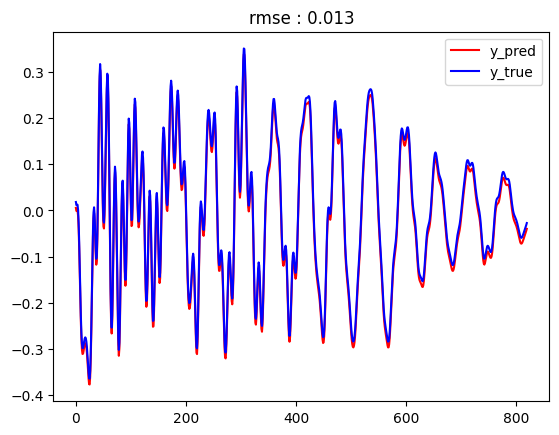

Training and evaluating for time series 8
epoch:10 train_loss:0.0006
validation_loss:0.0002
epoch:20 train_loss:0.0006
validation_loss:0.0002
epoch:30 train_loss:0.0006
validation_loss:0.0002


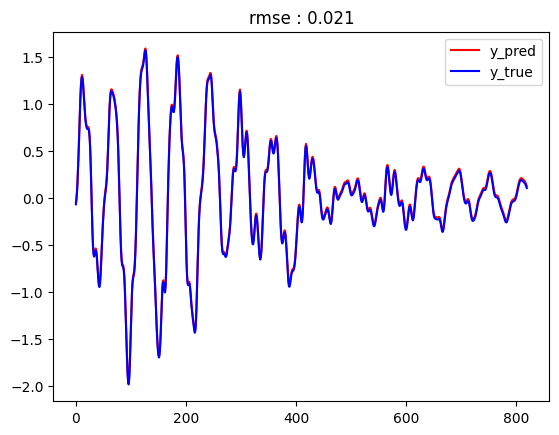

Training and evaluating for time series 9
epoch:10 train_loss:0.0006
validation_loss:0.0002
epoch:20 train_loss:0.0006
validation_loss:0.0002
epoch:30 train_loss:0.0006
validation_loss:0.0002


Training and evaluating for time series 10
epoch:10 train_loss:0.0001
validation_loss:0.0000
epoch:20 train_loss:0.0001
validation_loss:0.0000
epoch:30 train_loss:0.0001
validation_loss:0.0000


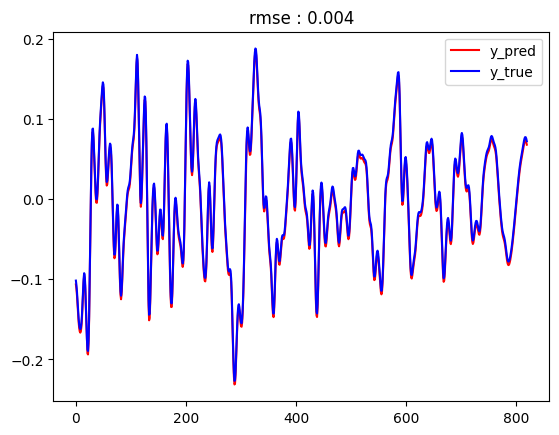

In [27]:
model = set_lstm(input_size=1, params=nn_parmas, DEVICE=DEVICE)

net_learning = Model_Learner(DEVICE=DEVICE, type='lstm')

model.train()

for i in range(len(train_scaled_list)):
    print(f"Training and evaluating for time series {i}")
    train_scaled = train_scaled_list[i]
    test_scaled = test_scaled_list[i]
    raw_values = train_dict['rawvalues'][i]
    len_supervised = train_dict['len_supervised'][i]
    train_scaled = np.squeeze(train_scaled)
    test_scaled = np.squeeze(test_scaled)

    # Create a new dataset for the current time series
    data_dict = {}
    data_dict['train_x'], data_dict['train_y'] = train_scaled[:, 0:-1], train_scaled[:, -1]
    data_dict['test_x'], data_dict['test_y'] = test_scaled[:, 0:-1], test_scaled[:, -1]
    
    # Train the model for the current time series
    model = net_learning.nn_learning(nn_model=model, ls_dict=nn_parmas, data_dict=data_dict)
    
    # Inversion of scaling and differencing for predictions
    hn, cn = model.hn, model.cn
    predictions = []
    model.eval()
    for j in range(len(data_dict['test_x'])):
        X, y = data_dict['test_x'][j, :], data_dict['test_y'][j]
        X = X.reshape(1, 1, len(X))
        hypothesis, (hn, cn) = model(torch.tensor(X, dtype=torch.float32), hn, cn)
        yhat = hypothesis.detach().numpy()[0, 0]
        yhat = invert_scale(scaler=scaler, X=X, value=yhat)
        yhat = inverse_difference(raw_values, yhat, len(data_dict['test_x']) + 1 - j)
        predictions.append(yhat)

    y_pred = predictions

    y_true = raw_values[train_size:len_supervised]
    # y_true = raw_values[train_size + i:train_size + len(data_dict['test_y']) + i]
    plt.plot(y_pred, 'r', label='y_pred')
    plt.plot(y_true, 'b', label='y_true')
    plt.title(f'rmse : {np.round(np.sqrt(np.mean(np.square(y_pred-y_true))), 3)}')
    plt.legend(loc='best')
    plt.show()

In [32]:
test_dict = {'test_x':[], 'rawvalues':[], 'len_supervised':[]}

In [33]:
for d in test_output_dataset:

    real_t = np.squeeze(d)
    
    raw_values = real_t

    test_dict['rawvalues'].append(raw_values)

    diff_values = difference(raw_values, 1)

    supervised = timeseries_to_supervised(diff_values, 1)
    
    supervised_values = supervised.values

    test_dict['len_supervised'].append(len(supervised_values))

    test_dict['test_x'].append(supervised_values)

test_dict['rawvalues'] = np.asarray(test_dict['rawvalues'])

test_dict['test_x'] = np.asarray(test_dict['test_x'])


In [34]:
nsamples_test = test_dict['test_x'].shape[0]
nxt, nyt = test_dict['test_x'].shape[1], test_dict['test_x'].shape[2]

real_test_set = test_dict['test_x'].reshape((nsamples_test*nxt,nyt))

real_test_scaled = scaler.transform(real_test_set)
real_test_scaled = real_test_scaled.reshape(nsamples_test, nxt, nyt)

In [38]:
real_test_scaled.shape

(3, 4096, 2)

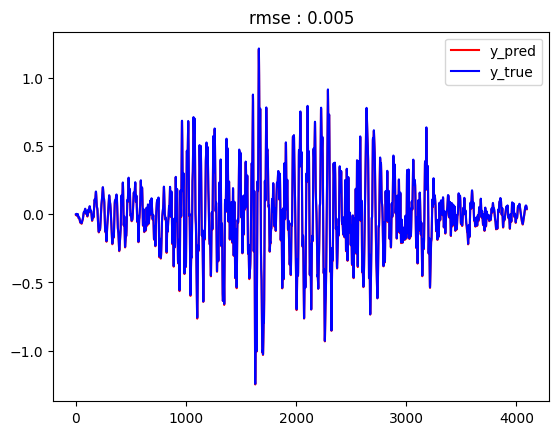

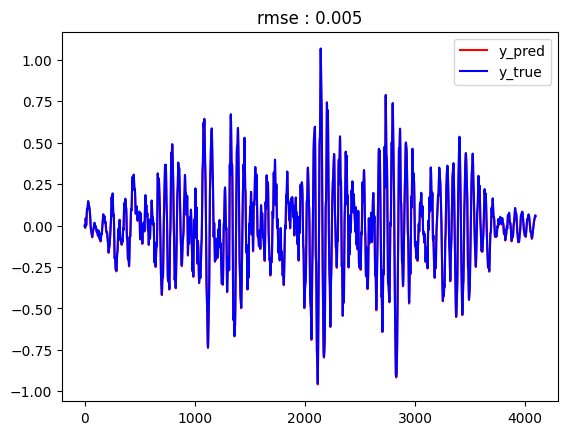

In [46]:
model.eval()
for i in range(len(real_test_scaled)):
    test_scaled = np.squeeze(real_test_scaled[i])
    raw_values = train_dict['rawvalues'][i]
    len_supervised = train_dict['len_supervised'][i]

    data_dict = {}
    data_dict['test_x'], data_dict['test_y'] = test_scaled[:, 0:-1], test_scaled[:, -1]

    hn, cn = model.hn, model.cn
    predictions = []
    
    for j in range(len(data_dict['test_x'])):
        X, y = data_dict['test_x'][j, :], data_dict['test_y'][j]
        X = X.reshape(1, 1, len(X))
        hypothesis, (hn, cn) = model(torch.tensor(X, dtype=torch.float32), hn, cn)
        yhat = hypothesis.detach().numpy()[0, 0]
        yhat = invert_scale(scaler=scaler, X=X, value=yhat)
        yhat = inverse_difference(raw_values, yhat, len(data_dict['test_x']) + 1 - j)
        predictions.append(yhat)

    
    y_pred = predictions

    y_true = raw_values[:len(predictions)]
    # y_true = raw_values[train_size + i:train_size + len(data_dict['test_y']) + i]
    plt.plot(y_pred, 'r', label='y_pred')
    plt.plot(y_true, 'b', label='y_true')
    plt.title(f'rmse : {np.round(np.sqrt(np.mean(np.square(y_pred-y_true))), 3)}')
    plt.legend(loc='best')
    plt.show()
